Data sourcing

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import data
data = pd.read_csv('loan.csv')

C:\Users\khang\AppData\Local\Temp\ipykernel_8716\3601201394.py:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('loan.csv')


Data cleaning

In [3]:
# preivew data
data

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39712,92187,92174,2500,2500,1075.0,36 months,8.07%,78.42,A,A4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39713,90665,90607,8500,8500,875.0,36 months,10.28%,275.38,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39714,90395,90390,5000,5000,1325.0,36 months,8.07%,156.84,A,A4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39715,90376,89243,5000,5000,650.0,36 months,7.43%,155.38,A,A2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#checking the count of NaN values in column 
data.iloc[:,:].isna().sum() 

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
                              ...  
tax_liens                        39
tot_hi_cred_lim               39717
total_bal_ex_mort             39717
total_bc_limit                39717
total_il_high_credit_limit    39717
Length: 111, dtype: int64

In [5]:
# remove columns contain 90% NaN values
filter_col = pd.DataFrame(data.dropna(axis=1, thresh=len(data)*0.9)) 

In [6]:
# review data for further cleaning
filter_col.head(100).style

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599,5000,5000,4975.000000,36 months,10.65%,162.870000,B,B2,nan,10+ years,RENT,24000.000000,Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=1077501,credit_card,Computer,860xx,AZ,27.650000,0,Jan-85,1,3,0,13648,83.70%,9,f,0.000000,0.000000,5863.155187,5833.840000,5000.000000,863.160000,0.000000,0.000000,0.000000,Jan-15,171.620000,May-16,0.000000,1,INDIVIDUAL,0,0.000000,0,0.000000,0.000000
1,1077430,1314167,2500,2500,2500.000000,60 months,15.27%,59.830000,C,C4,Ryder,< 1 year,RENT,30000.000000,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.action?loan_id=1077430,car,bike,309xx,GA,1.000000,0,Apr-99,5,3,0,1687,9.40%,4,f,0.000000,0.000000,1008.710000,1008.710000,456.460000,435.170000,0.000000,117.080000,1.110000,Apr-13,119.660000,Sep-13,0.000000,1,INDIVIDUAL,0,0.000000,0,0.000000,0.000000
2,1077175,1313524,2400,2400,2400.000000,36 months,15.96%,84.330000,C,C5,nan,10+ years,RENT,12252.000000,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=1077175,small_business,real estate business,606xx,IL,8.720000,0,Nov-01,2,2,0,2956,98.50%,10,f,0.000000,0.000000,3005.666844,3005.670000,2400.000000,605.670000,0.000000,0.000000,0.000000,Jun-14,649.910000,May-16,0.000000,1,INDIVIDUAL,0,0.000000,0,0.000000,0.000000
3,1076863,1277178,10000,10000,10000.000000,36 months,13.49%,339.310000,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.000000,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=1076863,other,personel,917xx,CA,20.000000,0,Feb-96,1,10,0,5598,21%,37,f,0.000000,0.000000,12231.890000,12231.890000,10000.000000,2214.920000,16.970000,0.000000,0.000000,Jan-15,357.480000,Apr-16,0.000000,1,INDIVIDUAL,0,0.000000,0,0.000000,0.000000
4,1075358,1311748,3000,3000,3000.000000,60 months,12.69%,67.790000,B,B5,University Medical Group,1 year,RENT,80000.000000,Source Verified,Dec-11,Current,n,https://lendingclub.com/browse/loanDetail.action?loan_id=1075358,other,Personal,972xx,OR,17.940000,0,Jan-96,0,15,0,27783,53.90%,38,f,524.060000,524.060000,3513.330000,3513.330000,2475.940000,1037.390000,0.000000,0.000000,0.000000,May-16,67.790000,May-16,0.000000,1,INDIVIDUAL,0,0.000000,0,0.000000,0.000000
5,1075269,1311441,5000,5000,5000.000000,36 months,7.90%,156.460000,A,A4,Veolia Transportaton,3 years,RENT,36000.000000,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=1075269,wedding,My wedding loan I promise to pay back,852xx,AZ,11.200000,0,Nov-04,3,9,0,7963,28.30%,12,f,0.000000,0.000000,5632.210000,5632.210000,5000.000000,632.210000,0.000000,0.000000,0.000000,Jan-15,161.030000,Jan-16,0.000000,1,INDIVIDUAL,0,0.000000,0,0.000000,0.000000
6,1069639,1304742,7000,7000,7000.000000,60 months,15.96%,170.080000,C,C5,Southern Star Photography,8 years,RENT,47004.000000,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=1069639,debt_consolidation,Loan,280xx,NC,23.510000,0,Jul-05,1,7,0,17726,85.60%,11,f,0.000000,0.000000,10110.840000,10110.840000,6985.610000,3125.230000,0.000000,0.000000,0.000000,May-16,1313.760000,May-16,0.000000,1,INDIVIDUAL,0,0.000000,0,0.000000,0.000000
7,1072053,1288686,3000,3000,3000.000000,36 months,18.64%,109.430000,E,E1,MKC Accounting,9 years,RENT,48000.0000

In [7]:
# drop columns contain 90% of repeated values
filter_col.drop(columns=filter_col.columns[filter_col.eq(0).mean()>0.89], inplace=True)
filter_col.drop(columns=filter_col.columns[filter_col.eq(1).mean()>0.90], inplace=True)
filter_col.drop(columns=filter_col.columns[filter_col.eq('f').mean()>0.90], inplace=True)
filter_col.drop(columns=filter_col.columns[filter_col.eq('n').mean()>0.90], inplace=True)
filter_col.drop(columns=filter_col.columns[filter_col.eq('INDIVIDUAL').mean()>0.90], inplace=True)

In [8]:
# reivew data after cleaning
filter_col.head(100).style

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,url,purpose,title,zip_code,addr_state,dti,earliest_cr_line,inq_last_6mths,open_acc,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d
0,1077501,1296599,5000,5000,4975.000000,36 months,10.65%,162.870000,B,B2,nan,10+ years,RENT,24000.000000,Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.action?loan_id=1077501,credit_card,Computer,860xx,AZ,27.650000,Jan-85,1,3,13648,83.70%,9,5863.155187,5833.840000,5000.000000,863.160000,Jan-15,171.620000,May-16
1,1077430,1314167,2500,2500,2500.000000,60 months,15.27%,59.830000,C,C4,Ryder,< 1 year,RENT,30000.000000,Source Verified,Dec-11,Charged Off,https://lendingclub.com/browse/loanDetail.action?loan_id=1077430,car,bike,309xx,GA,1.000000,Apr-99,5,3,1687,9.40%,4,1008.710000,1008.710000,456.460000,435.170000,Apr-13,119.660000,Sep-13
2,1077175,1313524,2400,2400,2400.000000,36 months,15.96%,84.330000,C,C5,nan,10+ years,RENT,12252.000000,Not Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.action?loan_id=1077175,small_business,real estate business,606xx,IL,8.720000,Nov-01,2,2,2956,98.50%,10,3005.666844,3005.670000,2400.000000,605.670000,Jun-14,649.910000,May-16
3,1076863,1277178,10000,10000,10000.000000,36 months,13.49%,339.310000,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.000000,Source Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.action?loan_id=1076863,other,personel,917xx,CA,20.000000,Feb-96,1,10,5598,21%,37,12231.890000,12231.890000,10000.000000,2214.920000,Jan-15,357.480000,Apr-16
4,1075358,1311748,3000,3000,3000.000000,60 months,12.69%,67.790000,B,B5,University Medical Group,1 year,RENT,80000.000000,Source Verified,Dec-11,Current,https://lendingclub.com/browse/loanDetail.action?loan_id=1075358,other,Personal,972xx,OR,17.940000,Jan-96,0,15,27783,53.90%,38,3513.330000,3513.330000,2475.940000,1037.390000,May-16,67.790000,May-16
5,1075269,1311441,5000,5000,5000.000000,36 months,7.90%,156.460000,A,A4,Veolia Transportaton,3 years,RENT,36000.000000,Source Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.action?loan_id=1075269,wedding,My wedding loan I promise to pay back,852xx,AZ,11.200000,Nov-04,3,9,7963,28.30%,12,5632.210000,5632.210000,5000.000000,632.210000,Jan-15,161.030000,Jan-16
6,1069639,1304742,7000,7000,7000.000000,60 months,15.96%,170.080000,C,C5,Southern Star Photography,8 years,RENT,47004.000000,Not Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.action?loan_id=1069639,debt_consolidation,Loan,280xx,NC,23.510000,Jul-05,1,7,17726,85.60%,11,10110.840000,10110.840000,6985.610000,3125.230000,May-16,1313.760000,May-16
7,1072053,1288686,3000,3000,3000.000000,36 months,18.64%,109.430000,E,E1,MKC Accounting,9 years,RENT,48000.000000,Source Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.action?loan_id=1072053,car,Car Downpayment,900xx,CA,5.350000,Jan-07,2,4,8221,87.50%,4,3939.135294,3939.140000,3000.000000,939.140000,Jan-15,111.340000,Dec-14
8,1071795,1306957,5600,5600,5600.000000,60 months,21.28%,152.390000,F,F2,nan,4 years,OWN,40000.000000,Source Verified,Dec-11,Charged Off,https://lendingclub.com/browse/loanDetail.action?loan_id=1071795,small_business,Expand Business & Buy Debt Portfolio,958xx,CA,5.550000,Apr-04,2,11,5210,32.60%,13,646.020000,646.020000,162.020000,294.940000,Apr-12,152.390000,Aug-12
9,1071570,1306721,5375,5375,5350.000000,60 months,12.69%,121.450000,B,B5,Starbucks,< 1 year,RENT,15000.000000,Verified,Dec-11,Charged Off,https://lendingclub.com/browse/loanDetail.action?loan_id=1071570,other,Building my credit history.,774xx,TX,18.080000,Sep-04,0,2,9279,36.50%,3,1476.190000,1469.340000,673.480000,533.420000,Nov-12,121.450000,Mar-13


Data pre-processing

In [9]:
# review current columns
filter_col.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'url', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'earliest_cr_line', 'inq_last_6mths', 'open_acc',
       'revol_bal', 'revol_util', 'total_acc', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'last_pymnt_d',
       'last_pymnt_amnt', 'last_credit_pull_d'],
      dtype='object')

In [41]:
# pick relevant columns
picked_cols = ['funded_amnt', 'term', 'int_rate', 'installment', 'grade', 
               'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 
               'verification_status', 'loan_status', 'purpose', 'addr_state', 
               'dti', 'revol_util']

# categorize column data type
num_cols = ['funded_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti', 'revol_util'] #numeric data type
cat_cols = ['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state','emp_length'] #categorical data type

In [42]:
# create new column for numeric defaulters
filter_col.loc[filter_col['loan_status'] == 'Charged Off','defaulters_count'] = 1
filter_col.loc[filter_col['loan_status'] != 'Charged Off','defaulters_count'] = 0

univariate analysis

term
 36 months    29096
 60 months    10621
Name: count, dtype: int64


C:\Users\khang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\khang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\khang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

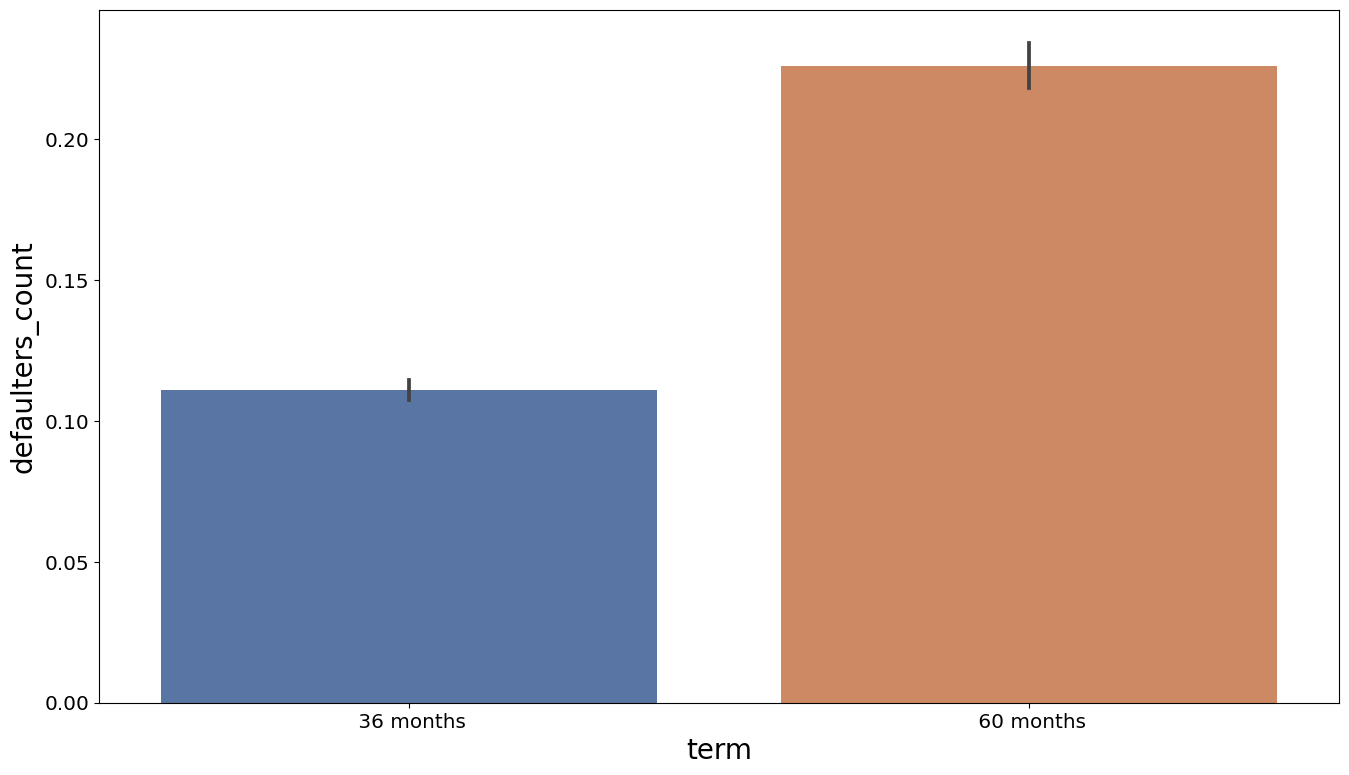

grade
B    12020
A    10085
C     8098
D     5307
E     2842
F     1049
G      316
Name: count, dtype: int64


C:\Users\khang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\khang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\khang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

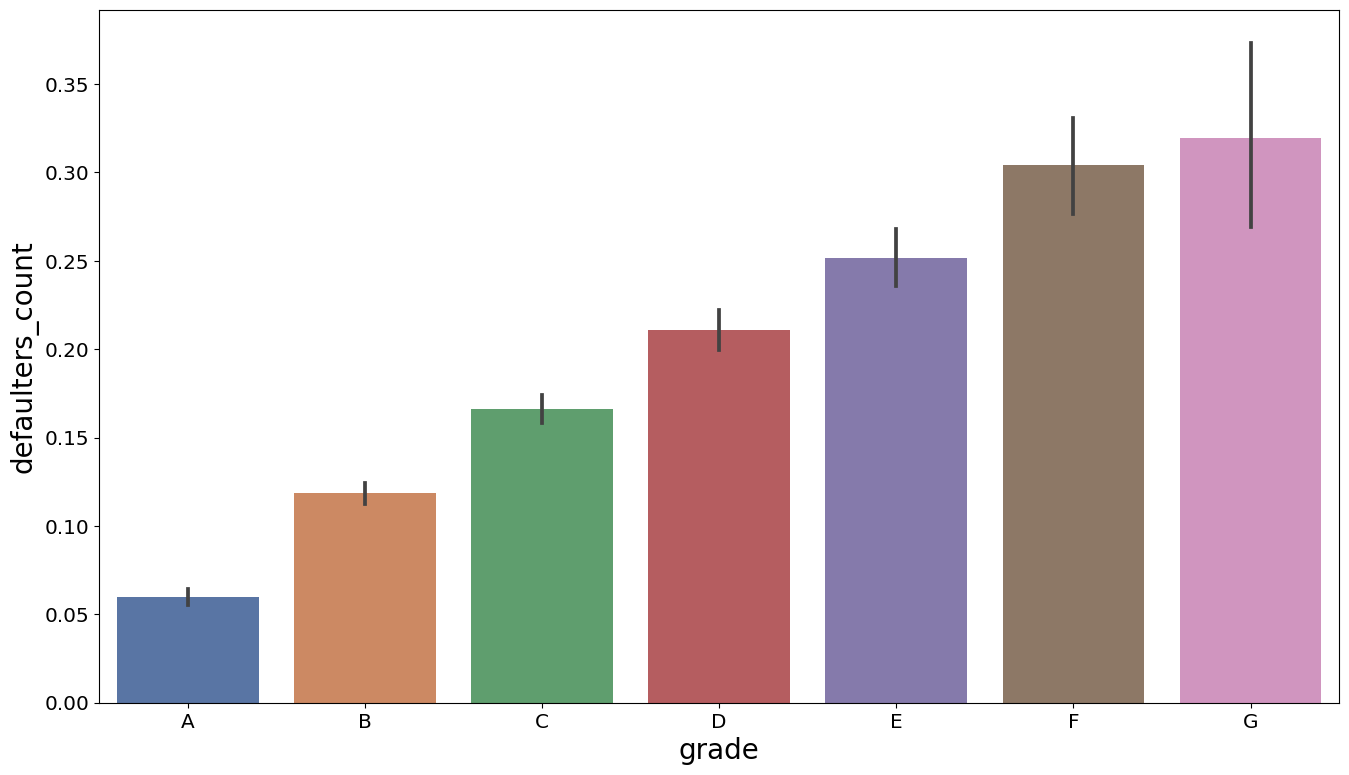

sub_grade
B3    2917
A4    2886
A5    2742
B5    2704
B4    2512
C1    2136
B2    2057
C2    2011
B1    1830
A3    1810
C3    1529
A2    1508
D2    1348
C4    1236
C5    1186
D3    1173
A1    1139
D4     981
D1     931
D5     874
E1     763
E2     656
E3     553
E4     454
E5     416
F1     329
F2     249
F3     185
F4     168
F5     118
G1     104
G2      78
G4      56
G3      48
G5      30
Name: count, dtype: int64


C:\Users\khang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\khang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\khang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

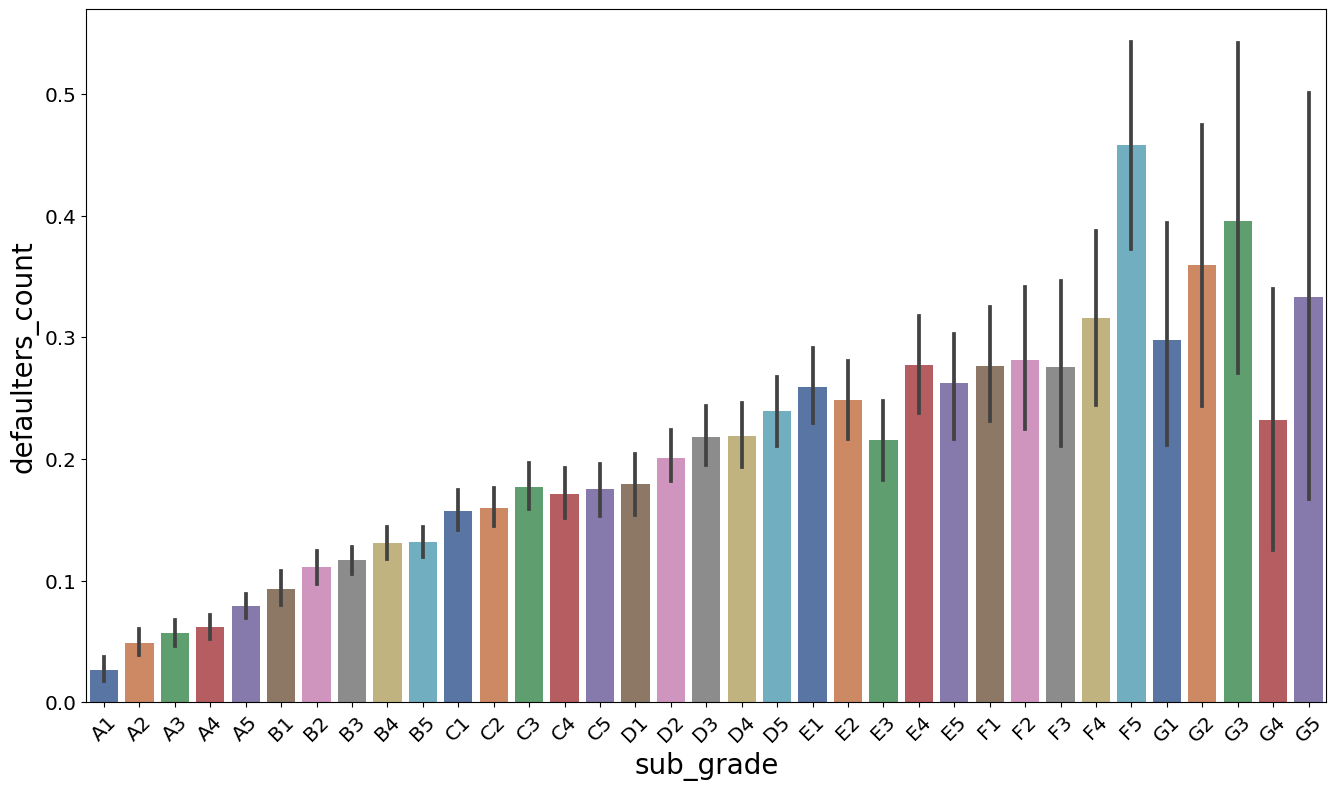

home_ownership
RENT        18899
MORTGAGE    17659
OWN          3058
OTHER          98
NONE            3
Name: count, dtype: int64


C:\Users\khang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\khang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\khang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

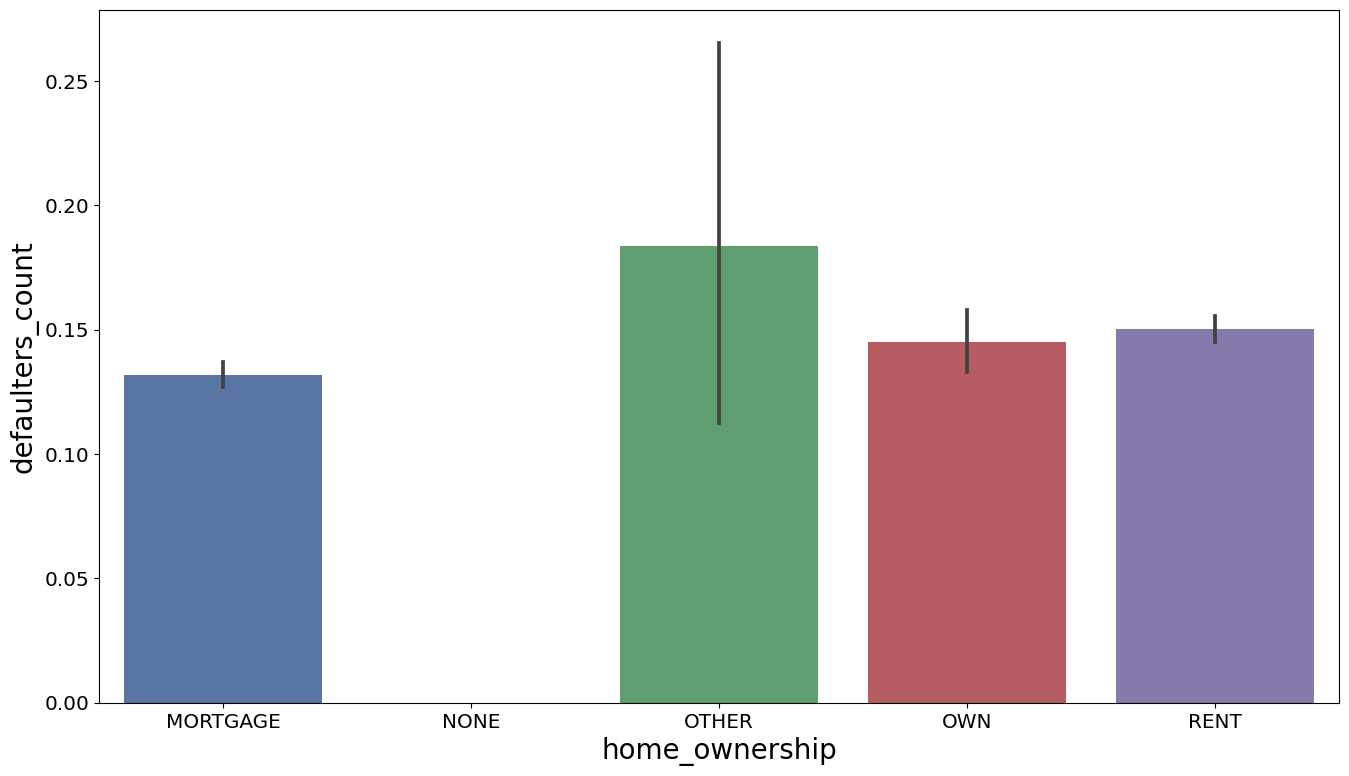

verification_status
Not Verified       16921
Verified           12809
Source Verified     9987
Name: count, dtype: int64


C:\Users\khang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\khang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\khang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

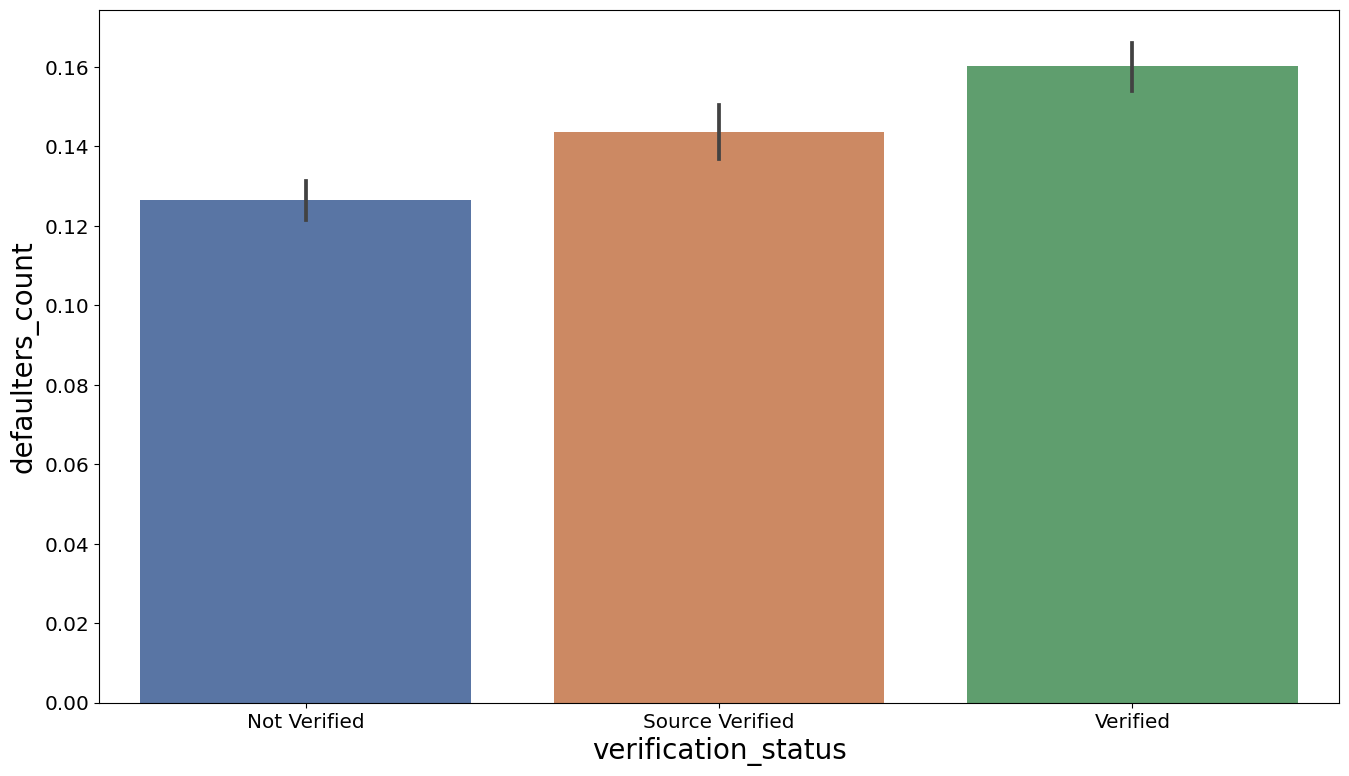

purpose
debt_consolidation    18641
credit_card            5130
other                  3993
home_improvement       2976
major_purchase         2187
small_business         1828
car                    1549
wedding                 947
medical                 693
moving                  583
vacation                381
house                   381
educational             325
renewable_energy        103
Name: count, dtype: int64


C:\Users\khang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\khang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\khang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

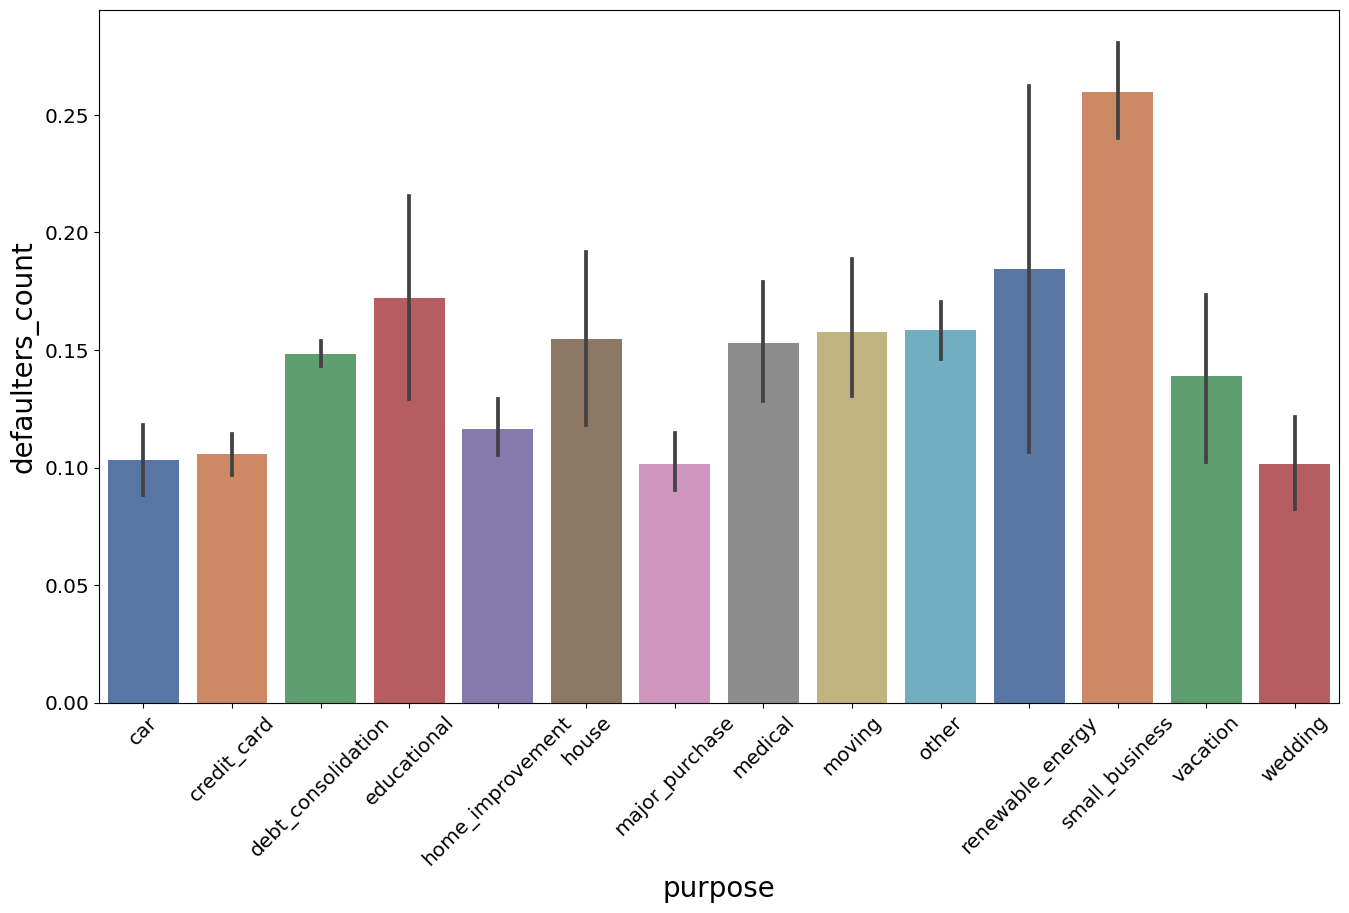

addr_state
CA    7099
NY    3812
FL    2866
TX    2727
NJ    1850
IL    1525
PA    1517
VA    1407
GA    1398
MA    1340
OH    1223
MD    1049
AZ     879
WA     840
CO     792
NC     788
CT     751
MI     720
MO     686
MN     615
NV     497
SC     472
WI     460
AL     452
OR     451
LA     436
KY     325
OK     299
KS     271
UT     258
AR     245
DC     214
RI     198
NM     189
WV     177
HI     174
NH     171
DE     114
MT      85
WY      83
AK      80
SD      64
VT      54
MS      19
TN      17
IN       9
ID       6
IA       5
NE       5
ME       3
Name: count, dtype: int64


C:\Users\khang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\khang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\khang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

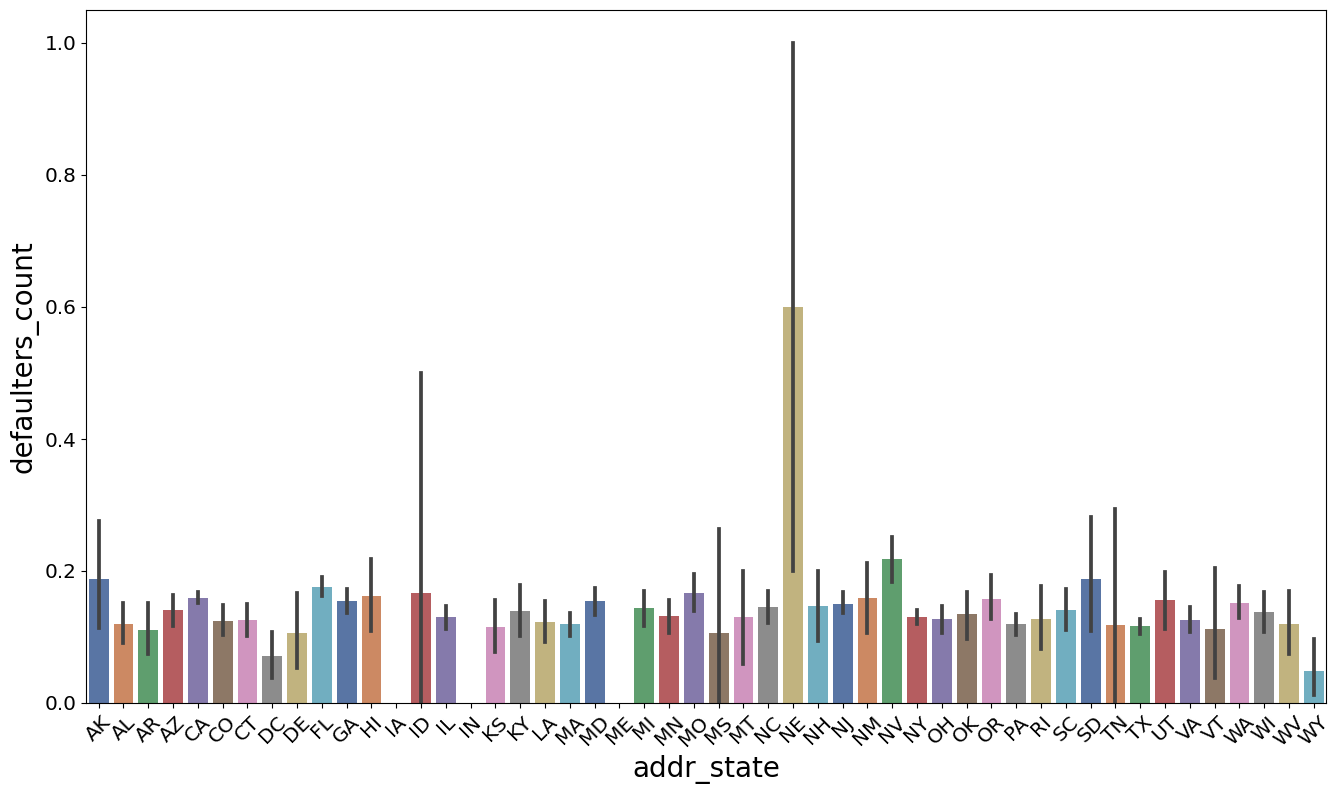

emp_length
10+ years    8879
< 1 year     4583
2 years      4388
3 years      4095
4 years      3436
5 years      3282
1 year       3240
6 years      2229
7 years      1773
8 years      1479
9 years      1258
Name: count, dtype: int64


C:\Users\khang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\khang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\khang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

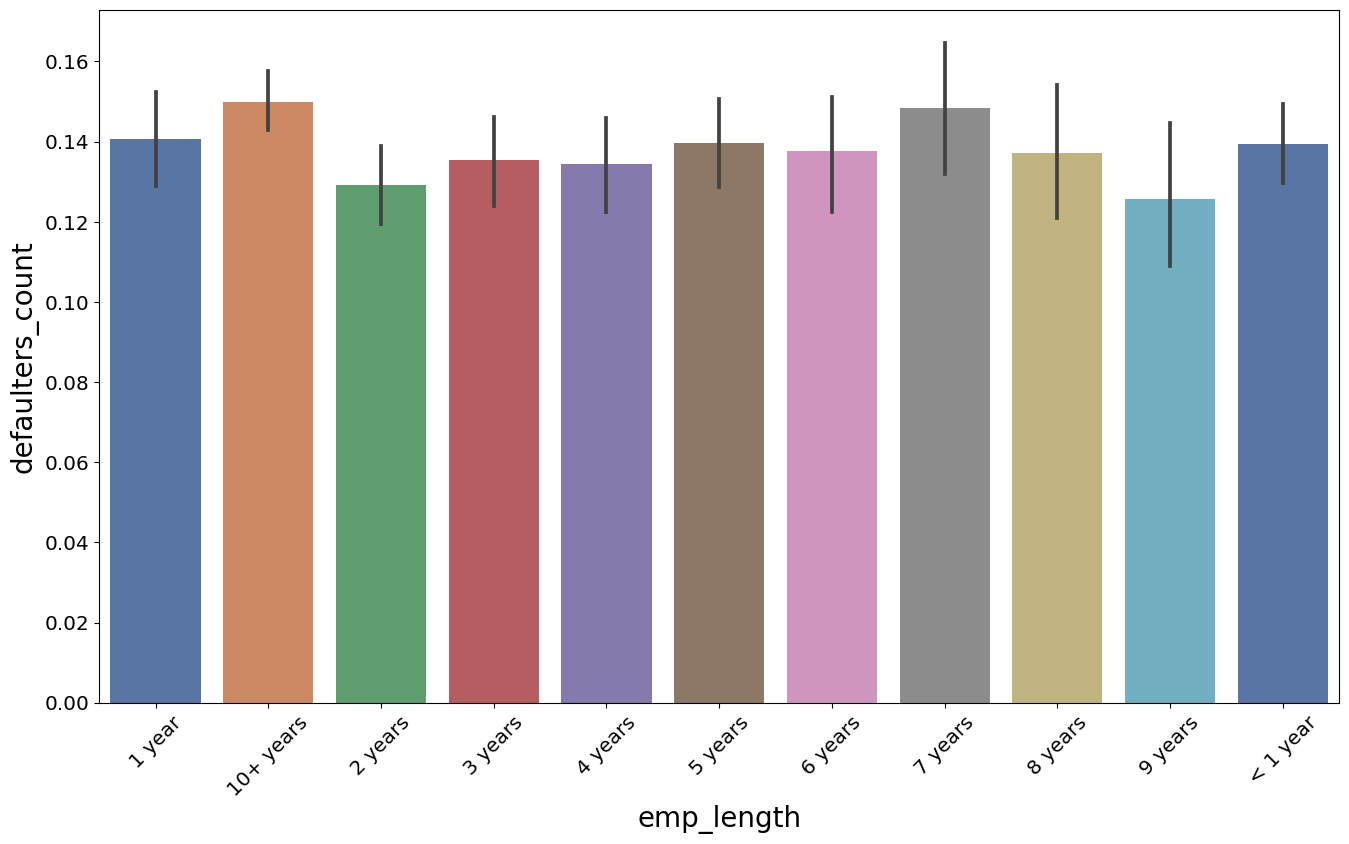

In [43]:
# create plot funtion with data segment argument vs defaulters in sorted order
def defaulters_plot(x_axis):
    sns.barplot(x=x_axis, y='defaulters_count', data=filter_col.sort_values(x_axis), palette='deep')

# gemerate plots for categorical data
plt.rcParams["figure.figsize"] = (16, 9)
for col in cat_cols:
    print(filter_col[col].value_counts())
    plt.xlabel(col, fontsize=20)
    plt.ylabel('defaulters_count',fontsize=20)
    plt.yticks(fontsize='x-large')
    plt.xticks(fontsize='x-large')    
    if filter_col.groupby(col)[col].count().index.size>10:
        plt.xticks(rotation=45, fontsize='x-large')        
    defaulters_plot(col)
    plt.show()

Yashasvi please explain the graphs above in this markdown

Yashasvi: data pre-processing

In [44]:
data.loan_status.value_counts()

loan_status
Fully Paid     32950
Charged Off     5627
Current         1140
Name: count, dtype: int64

In [45]:
data.home_ownership.value_counts()

home_ownership
RENT        18899
MORTGAGE    17659
OWN          3058
OTHER          98
NONE            3
Name: count, dtype: int64

In [46]:
data.verification_status.value_counts()

verification_status
Not Verified       16921
Verified           12809
Source Verified     9987
Name: count, dtype: int64

In [47]:
cn = data.loan_status.value_counts()

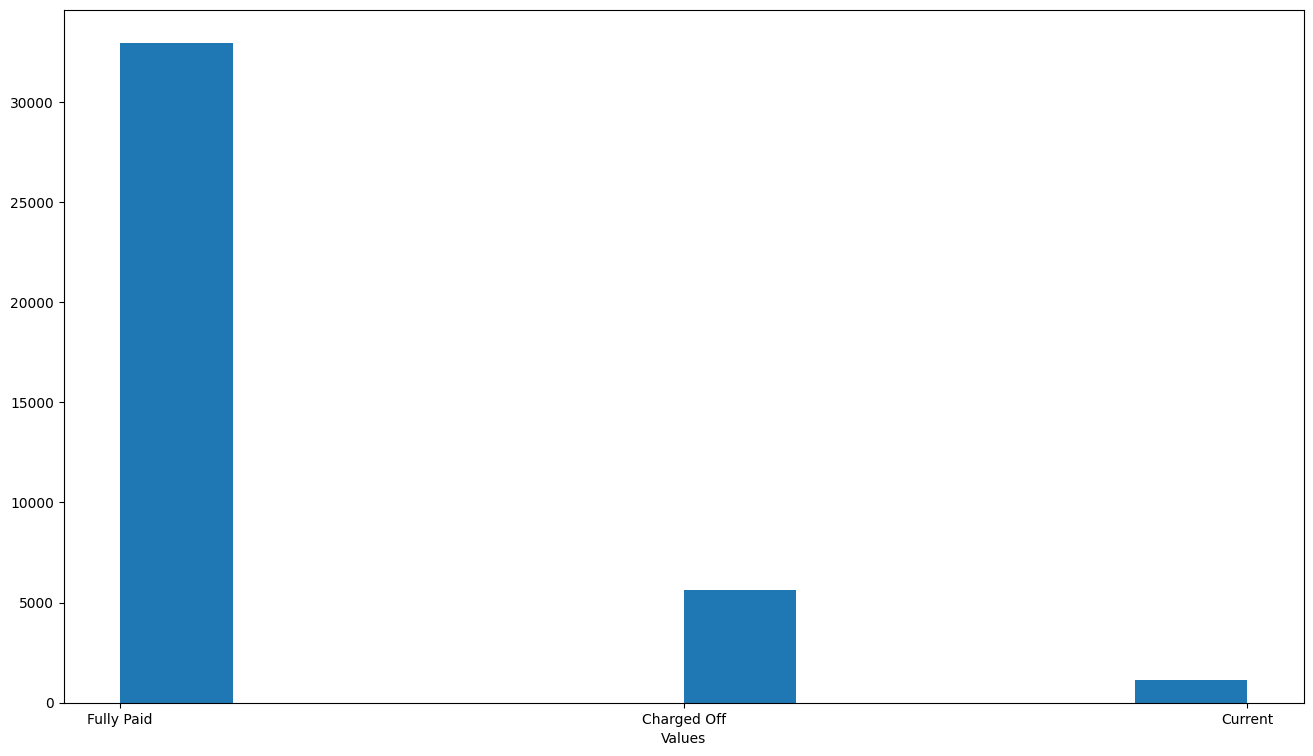

In [48]:
import matplotlib.pyplot as plt


plt.hist(data['loan_status'], bins=10)  
plt.xlabel('Values')
plt.show()